<a href="https://colab.research.google.com/github/prysykes/adversarial_attacks/blob/main/PGD_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
pathh = 'MNISTClassifier'

for parent, dirs, files in os.walk(pathh, topdown=False):
  for file in files:
    file_path = os.path.join(parent, file)
    os.remove(file_path)
  for dir in dirs:
    dir_path = os.path.join(parent, dir)
    os.rmdir(dir_path)
  
  os.rmdir('/content/MNISTClassifier')

In [3]:
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape(60000, 28, 28).astype("float32")/255
images = np.expand_dims(images, axis=3)
test_images = test_images.reshape(10000, 28, 28).astype("float32")/255
test_images = np.expand_dims(test_images, axis=3)
x_train, x_test = images[10000:], images[:10000]
y_train, y_test = labels[10000:], labels[:10000]

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
print(len(x_train))
x_train, x_val = x_train[10000:], x_train[0:10000]
y_train, y_val = y_train[10000:], y_train[0:10000]
print(len(x_train))

50000
40000


2


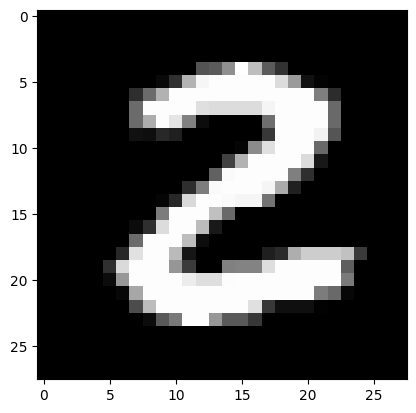

In [5]:
x_test[5].shape
digit = x_test[25]
fig = plt.figure
plt.imshow(digit, cmap='gray')
print(y_test[16])


In [6]:
few_fives = []
count = 0
for index, label in enumerate(y_test):
  if count > 4:
    break
  if label == 5:
    few_fives.append((index, label))
    count += 1

print(few_fives)

[(0, 5), (11, 5), (35, 5), (47, 5), (65, 5)]


In [7]:
class MNISTClassifier(tf.keras.Model):
  def __init__(self):
    super(MNISTClassifier, self).__init__()

    #define the layers for feature extracture
    self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1))
    self.max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
    self.max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.flatten = tf.keras.layers.Flatten()
    self.dropout1 = tf.keras.layers.Dropout(0.25)
    self.dense1 = tf.keras.layers.Dense(128, activation='relu')
    self.dropout2 = tf.keras.layers.Dropout(0.5)
    self.dense2 = tf.keras.layers.Dense(10)
    self.layers_list = [self.conv1, self.max_pool1, self.conv2, self.max_pool2,
                        self.flatten, self.dropout1, self.dense1, self.dropout2, self.dense2]
  
  @tf.function
  def call(self, *args, **kwargs):
    #define forward pass
    #output is model logits

    activation_list = []
    out = args[0]
    for layer in self.layers_list:
      out = layer(out)
      activation_list.append(out)
    
    return out



In [8]:
model = MNISTClassifier()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

model.save('MNISTClassifier')
model.summary()


Epoch 1/10
1250/1250 [==============================] - 18s 5ms/step - loss: 0.2719 - accuracy: 0.9160 - val_loss: 0.0713 - val_accuracy: 0.9780
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1000 - accuracy: 0.9708 - val_loss: 0.0482 - val_accuracy: 0.9855
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0761 - accuracy: 0.9777 - val_loss: 0.0388 - val_accuracy: 0.9873
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0613 - accuracy: 0.9814 - val_loss: 0.0362 - val_accuracy: 0.9883
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0526 - accuracy: 0.9841 - val_loss: 0.0338 - val_accuracy: 0.9902
Epoch 6/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0453 - accuracy: 0.9862 - val_loss: 0.0289 - val_accuracy: 0.9906
Epoch 7/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0422 - accuracy: 0.9872 - val_loss: 0.0294 - val_accuracy

Model: "mnist_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  320       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dropout (Dropout)           multiple             

In [9]:
model = tf.keras.models.load_model('MNISTClassifier')

In [10]:
fives_tupple = [(0, 5), (11, 5), (35, 5), (47, 5), (65, 5)]
reshaped_sample_fives = []

for tup in fives_tupple:
  a_five = x_test[tup[0]]
  a_five = np.reshape(a_five, (-1, 28, 28, 1))
  reshaped_sample_fives.append(a_five)

reshaped_sample_fives = np.array(reshaped_sample_fives)

In [18]:
print(np.argmax(x_test[0]))

161


In [11]:
print(reshaped_sample_fives.shape)

(5, 1, 28, 28, 1)


<class 'numpy.ndarray'>


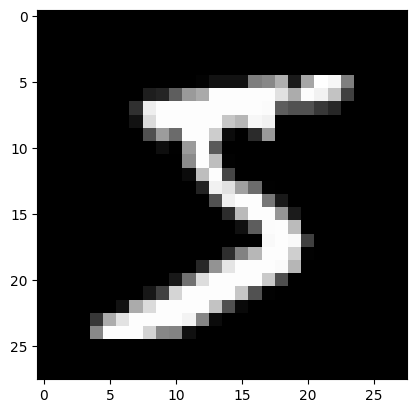

In [15]:
plt.imshow(np.squeeze(reshaped_sample_fives[0], axis=0), cmap='gray')
print(type(reshaped_sample_fives[0]))

In [16]:
predictions = []
for sample in reshaped_sample_fives:
  sample_prediction = model.predict(sample)
  predictions.append(sample_prediction)

print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 49ms/step
5


In [22]:
print(predictions[0].shape)

(1, 10)


In [21]:
print(model(reshaped_sample_fives[0]))

tf.Tensor(
[[-10.694927    -9.121318   -12.539305     5.8535757  -17.870321
   11.550816    -6.6937137   -9.457018    -5.4171495   -0.39799905]], shape=(1, 10), dtype=float32)


In [63]:
def pgd_attack(model, x, y, epsilon, alpha, num_iter):
  #Generate adversarial example using PGD

  x_adv = tf.Variable(x, dtype=tf.float32)
  # Initialize the adversarial example as the origianl copy of the input image

  for _ in range(num_iter):
    with tf.GradientTape() as tape:
      tape.watch(x_adv)
      logits = model(x_adv)
      # print("shape y", y.shape)
      # print("shape logit", logits.shape)
      loss = tf.keras.losses.CategoricalCrossentropy()(y, logits)
    
    #compute gradients of the loss wrt the adversarial example
    gradients = tape.gradient(loss, x_adv)

    #Update the adversarial example by taking a small step in the direction of the gradient
    x_adv = x_adv + alpha * tf.sign(gradients)

    # Project the perturbed example back onto the epsilon-ball arround the original inout
    perturbation = tf.clip_by_value(x_adv -x, -epsilon, epsilon)

    x_adv = tf.clip_by_value(x + perturbation, 0, 1)

  return x_adv



In [24]:
reshaped_sample_fives[0].shape

(1, 28, 28, 1)

In [35]:
x = reshaped_sample_fives[0]
print(x.shape)

(1, 28, 28, 1)


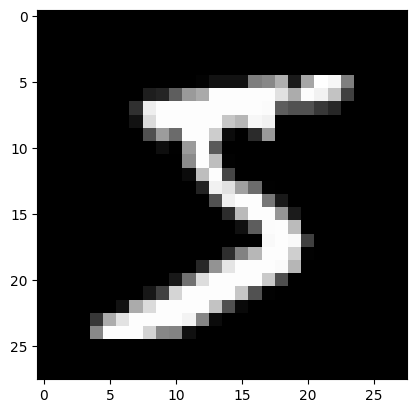

In [27]:
plt.imshow(np.squeeze(reshaped_sample_fives[0], axis=0), cmap='gray')

In [64]:
# print(y_test[0])
# y = tf.one_hot(y_test[0], 10)
# y = np.array(y)
# print(y)
# y = np.expand_dims(y, axis=0)
# print(y.shape)

In [67]:
y = model.predict(x)

1/1 [==============================] - 0s 31ms/step


In [101]:
epsilon, alpha, num_iter = 0.15, 0.01, 100

In [102]:
adv_img = pgd_attack(model, x, y, epsilon, alpha, num_iter)

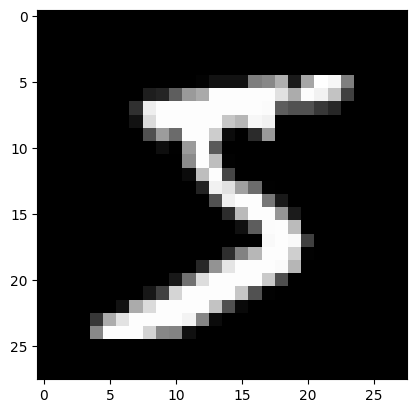

In [50]:
plt.imshow(np.squeeze(x, axis=0), cmap='gray')

In [103]:
predicte = model.predict(adv_img)

print(np.argmax(predicte))

1/1 [==============================] - 0s 27ms/step
5


(1, 28, 28, 1)


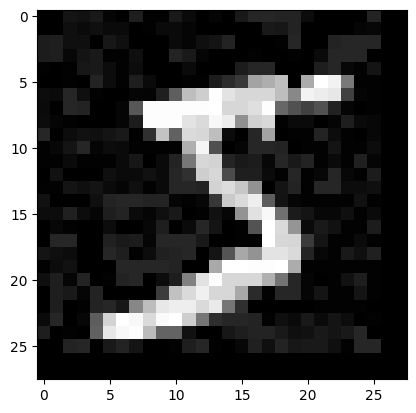

In [104]:
print(adv_img.shape)
plt.imshow(np.squeeze(adv_img, axis=0), cmap='gray')